# PacketPatrolAI - AI based Network Attack Detection

Luca Di Bello (luca.dibello@student.supsi.ch) - SUPSI - 2021

## Dataset description

The dataset used for this project is written in the NetFlow V9 format (format by Cisco, documentation available [here](https://www.cisco.com/en/US/technologies/tk648/tk362/technologies_white_paper09186a00800a3db9.html)). The dataset is composed by two files:

* **train_set**: ~2 million flows, used for training the model
* **test_set**: ~4 million flows, used for testing the model

### Columns
* **FLOW_ID**: A unique identifier for the flow
* **PROTOCOL_MAP**: A string representing the protocol used in the flow, possible values include "ICMP", "TCP", "UDP", "IGMP", "GRE", "ESP", "AH", "EIGRP", "OSPF", "PIM", "IPV6-ICMP", "IPV6-IP", "IPV6-ROUTE", "IPV6-FRAG", "IPV6-NONXT", "IPV6-OPTS", and others.
* **L4_SRC_PORT**: The source port number in the flow, possible values range from 0 to 65535.
* **IPV4_SRC_ADDR**: The source IPv4 address in the flow, represented as a string in dotted decimal notation (e.g., "192.168.0.1").
* **L4_DST_PORT**: The destination port number in the flow, possible values range from 0 to 65535.
* **IPV4_DST_ADDR**: The destination IPv4 address in the flow, represented as a string in dotted decimal notation (e.g., "192.168.0.2").
* **FIRST_SWITCHED**: The time at which the flow started, measured in seconds since the epoch (January 1, 1970).
* **FLOW_DURATION_MILLISECONDS**: The duration of the flow in milliseconds.
* **LAST_SWITCHED**: The time at which the flow ended, measured in seconds since the epoch (January 1, 1970).
* **PROTOCOL**: The protocol used in the flow, possible values include 1 (ICMP), 6 (TCP), 17 (UDP), and others.
* **TCP_FLAGS**: The TCP flags set in the flow, represented as a binary string (e.g., "100101").
* **TCP_WIN_MAX_IN**: The maximum advertised window size (in bytes) for incoming traffic.
* **TCP_WIN_MAX_OUT**: The maximum advertised window size (in bytes) for outgoing traffic.
* **TCP_WIN_MIN_IN**: The minimum advertised window size (in bytes) for incoming traffic.
* **TCP_WIN_MIN_OUT**: The minimum advertised window size (in bytes) for outgoing traffic.
* **TCP_WIN_MSS_IN**: The maximum segment size (in bytes) for incoming traffic.
* **TCP_WIN_SCALE_IN**: The window scale factor for incoming traffic.
* **TCP_WIN_SCALE_OUT**: The window scale factor for outgoing traffic.
* **SRC_TOS**: The Type of Service (ToS) value for the source IP address.
* **DST_TOS**: The Type of Service (ToS) value for the destination IP address.
* **TOTAL_FLOWS_EXP**: The total number of expected flows.
* **MIN_IP_PKT_LEN**: The minimum length (in bytes) of IP packets in the flow.
* **MAX_IP_PKT_LEN**: The maximum length (in bytes) of IP packets in the flow.
* **TOTAL_PKTS_EXP**: The total number of expected packets in the flow.
* **TOTAL_BYTES_EXP**: The total number of expected bytes in the flow.
* **IN_BYTES**: The number of bytes received in the flow.
* **IN_PKTS**: The number of packets received in the flow.
* **OUT_BYTES**: The number of bytes sent in the flow.
* **OUT_PKTS**: The number of packets sent in the flow.
* **ANALYSIS_TIMESTAMP**: The time at which the flow was analyzed, measured in seconds since the epoch (January 1, 1970).
* **ANOMALY**: A binary flag indicating whether the flow contains an anomaly (1 = true, 0 = false).
* **ALERT**: (<u>only available in training set</u>) The kind of attack that has been detected on the current flow. This are the possible values:
  - **None**: No attack has been detected
  - **Port scanning**: The flow is a port scanning attack 
  - **Denial of Service**: The flow is a DoS attack
  - **Malware**: The flow is a malware attack
* **ID**: A unique identifier for the flow.

## 1. Loading the datasets

In [190]:
# Load data processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

In [191]:
# Load machine learning libraries
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import RocCurveDisplay, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [192]:
# If true, only the 3% of the data will be used for training and testing of the various models
_DEVMODE = True

In [193]:
# Loading the data from the train and test files
train_df = pd.read_csv('data/train_net.csv')
test_df = pd.read_csv('data/test_net.csv')

In [194]:
# Print total size
print("Test set size: ", test_df.shape)
print("Train set size: ", train_df.shape)

# Value counts
train_df['ALERT'].value_counts()

Test set size:  (2077339, 32)
Train set size:  (4217625, 33)


None                 3659000
Port Scanning         507845
Denial of Service      50392
Malware                  388
Name: ALERT, dtype: int64

In [195]:
if _DEVMODE:
    train_df = train_df.sample(frac=0.03, random_state=1)
    test_df = test_df.sample(frac=0.03, random_state=1)

    # Print total size
    print("Test set size: ", test_df.shape)
    print("Train set size: ", train_df.shape)


Test set size:  (62320, 32)
Train set size:  (126529, 33)


## 2. Data Preprocessing

### Print datasets information

In [196]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126529 entries, 1283232 to 959711
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FLOW_ID                     126529 non-null  int64  
 1   PROTOCOL_MAP                126529 non-null  object 
 2   L4_SRC_PORT                 126529 non-null  int64  
 3   IPV4_SRC_ADDR               126529 non-null  object 
 4   L4_DST_PORT                 126529 non-null  int64  
 5   IPV4_DST_ADDR               126529 non-null  object 
 6   FIRST_SWITCHED              126529 non-null  int64  
 7   FLOW_DURATION_MILLISECONDS  126529 non-null  int64  
 8   LAST_SWITCHED               126529 non-null  int64  
 9   PROTOCOL                    126529 non-null  int64  
 10  TCP_FLAGS                   126529 non-null  int64  
 11  TCP_WIN_MAX_IN              126529 non-null  int64  
 12  TCP_WIN_MAX_OUT             126529 non-null  int64  
 13  TCP_WIN_

In [197]:
# Show information about the data
def printInfo(df):
    print('Dataframe shape: ', df.shape)
    print('Dataframe columns: ', df.columns)

print('==== Train data ====')
printInfo(train_df)
print()
print('==== Test data ====')
printInfo(test_df)

==== Train data ====
Dataframe shape:  (126529, 33)
Dataframe columns:  Index(['FLOW_ID', 'PROTOCOL_MAP', 'L4_SRC_PORT', 'IPV4_SRC_ADDR',
       'L4_DST_PORT', 'IPV4_DST_ADDR', 'FIRST_SWITCHED',
       'FLOW_DURATION_MILLISECONDS', 'LAST_SWITCHED', 'PROTOCOL', 'TCP_FLAGS',
       'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT', 'TCP_WIN_MIN_IN',
       'TCP_WIN_MIN_OUT', 'TCP_WIN_MSS_IN', 'TCP_WIN_SCALE_IN',
       'TCP_WIN_SCALE_OUT', 'SRC_TOS', 'DST_TOS', 'TOTAL_FLOWS_EXP',
       'MIN_IP_PKT_LEN', 'MAX_IP_PKT_LEN', 'TOTAL_PKTS_EXP', 'TOTAL_BYTES_EXP',
       'IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS', 'ANALYSIS_TIMESTAMP',
       'ANOMALY', 'ALERT', 'ID'],
      dtype='object')

==== Test data ====
Dataframe shape:  (62320, 32)
Dataframe columns:  Index(['FLOW_ID', 'PROTOCOL_MAP', 'L4_SRC_PORT', 'IPV4_SRC_ADDR',
       'L4_DST_PORT', 'IPV4_DST_ADDR', 'FIRST_SWITCHED',
       'FLOW_DURATION_MILLISECONDS', 'LAST_SWITCHED', 'PROTOCOL', 'TCP_FLAGS',
       'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT', '

In [198]:
train_df.head()

,FLOW_ID,PROTOCOL_MAP,L4_SRC_PORT,IPV4_SRC_ADDR,L4_DST_PORT,IPV4_DST_ADDR,FIRST_SWITCHED,FLOW_DURATION_MILLISECONDS,LAST_SWITCHED,PROTOCOL,...,TOTAL_PKTS_EXP,TOTAL_BYTES_EXP,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,ANALYSIS_TIMESTAMP,ANOMALY,ALERT,ID
1283232,372246818,tcp,62980,10.114.241.166,47736,10.114.224.117,1647766047,0,1647766047,6,...,0,0,44,1,40,1,1647766568,0.0,Port Scanning,1283232
3327778,372024895,udp,44246,10.114.227.143,53,10.114.226.5,1647761040,0,1647761040,17,...,0,0,73,1,121,1,1647761116,0.0,None,3327778
3341312,334833539,tcp,36150,10.114.225.212,5228,74.125.133.188,1647346083,144,1647346083,6,...,0,0,132,2,130,2,1647346141,NaN,None,3341312
1704357,369619889,tcp,33858,10.114.225.206,6443,10.114.232.94,1647693586,0,1647693586,6,...,0,0,60,1,0,0,1647693660,1.0,None,1704357
4163521,371759146,udp,48586,10.114.227.52,53,10.114.226.5,1647752706,0,1647752706,17,...,0,0,91,1,146,1,1647752852,0.0,None,4163521


### Check for missing values

In [199]:
# Check for missing values
print('==== Train data ====')
print(train_df.isnull().sum())
print()
print('==== Test data ====')
print(test_df.isnull().sum())
print()

==== Train data ====
FLOW_ID                           0
PROTOCOL_MAP                      0
L4_SRC_PORT                       0
IPV4_SRC_ADDR                     0
L4_DST_PORT                       0
IPV4_DST_ADDR                     0
FIRST_SWITCHED                    0
FLOW_DURATION_MILLISECONDS        0
LAST_SWITCHED                     0
PROTOCOL                          0
TCP_FLAGS                         0
TCP_WIN_MAX_IN                    0
TCP_WIN_MAX_OUT                   0
TCP_WIN_MIN_IN                    0
TCP_WIN_MIN_OUT                   0
TCP_WIN_MSS_IN                    0
TCP_WIN_SCALE_IN                  0
TCP_WIN_SCALE_OUT                 0
SRC_TOS                           0
DST_TOS                           0
TOTAL_FLOWS_EXP                   0
MIN_IP_PKT_LEN                    0
MAX_IP_PKT_LEN                    0
TOTAL_PKTS_EXP                    0
TOTAL_BYTES_EXP                   0
IN_BYTES                          0
IN_PKTS                           0
OUT_BYT

### Fill missing **ANOMALY** values

In [200]:
# Fill the missing ANOMALY values with 0 (no anomaly)
train_df['ANOMALY'].fillna(0, inplace=True)
test_df['ANOMALY'].fillna(0, inplace=True)

### Check if **ANOMALY** is related to **ALERT**

Answer: No, **ANOMALY** is not related to **ALERT**.

<Axes: xlabel='ALERT', ylabel='count'>

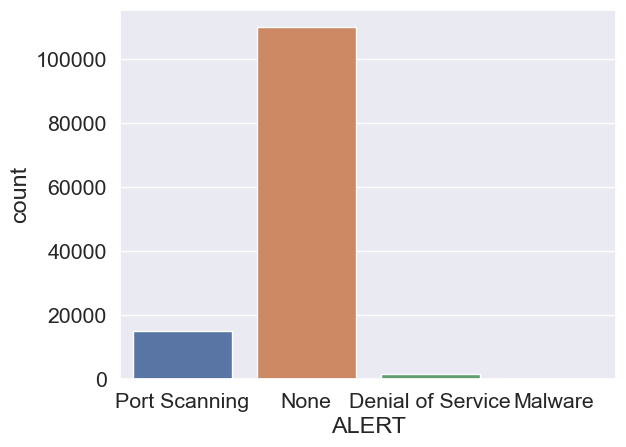

In [201]:
# Check if "ANOMALY" is related to "ALERT"
sns.countplot(x='ALERT', data=train_df)

## 3. Data Analysis

### Data types

In [202]:
train_df.dtypes

FLOW_ID                         int64
PROTOCOL_MAP                   object
L4_SRC_PORT                     int64
IPV4_SRC_ADDR                  object
L4_DST_PORT                     int64
IPV4_DST_ADDR                  object
FIRST_SWITCHED                  int64
FLOW_DURATION_MILLISECONDS      int64
LAST_SWITCHED                   int64
PROTOCOL                        int64
TCP_FLAGS                       int64
TCP_WIN_MAX_IN                  int64
TCP_WIN_MAX_OUT                 int64
TCP_WIN_MIN_IN                  int64
TCP_WIN_MIN_OUT                 int64
TCP_WIN_MSS_IN                  int64
TCP_WIN_SCALE_IN                int64
TCP_WIN_SCALE_OUT               int64
SRC_TOS                         int64
DST_TOS                         int64
TOTAL_FLOWS_EXP                 int64
MIN_IP_PKT_LEN                  int64
MAX_IP_PKT_LEN                  int64
TOTAL_PKTS_EXP                  int64
TOTAL_BYTES_EXP                 int64
IN_BYTES                        int64
IN_PKTS     

### 3.1. Observing the distribution of the target variable

We can observe that the dataset is highly imbalanced, with the majority of the flows being normal (no attack detected). We can also observe that also the number of malware attacks is very low, compared to the other attacks.

These two facts will have a big impact on the model training, as we will see later.

<Axes: xlabel='ALERT', ylabel='count'>

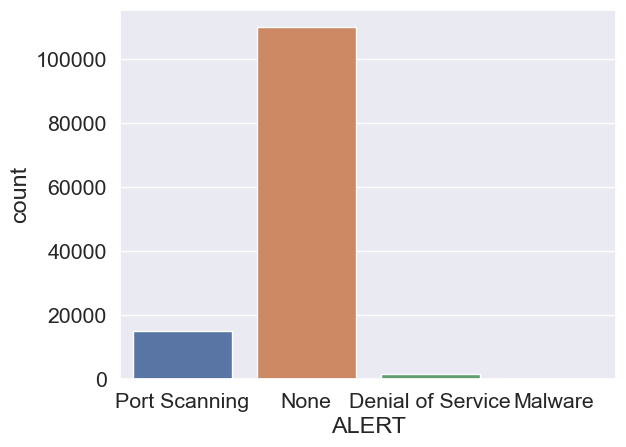

In [203]:
# Show the distribution of the target variable
sns.countplot(x='ALERT', data=train_df)

In [204]:
# Count the number of unique protocol_maps
train_df['PROTOCOL_MAP'].value_counts()

tcp          62514
udp          54250
icmp          9728
gre             36
ipv6-icmp        1
Name: PROTOCOL_MAP, dtype: int64

[Text(0.5, 1.0, 'L4_SRC_PORT')]

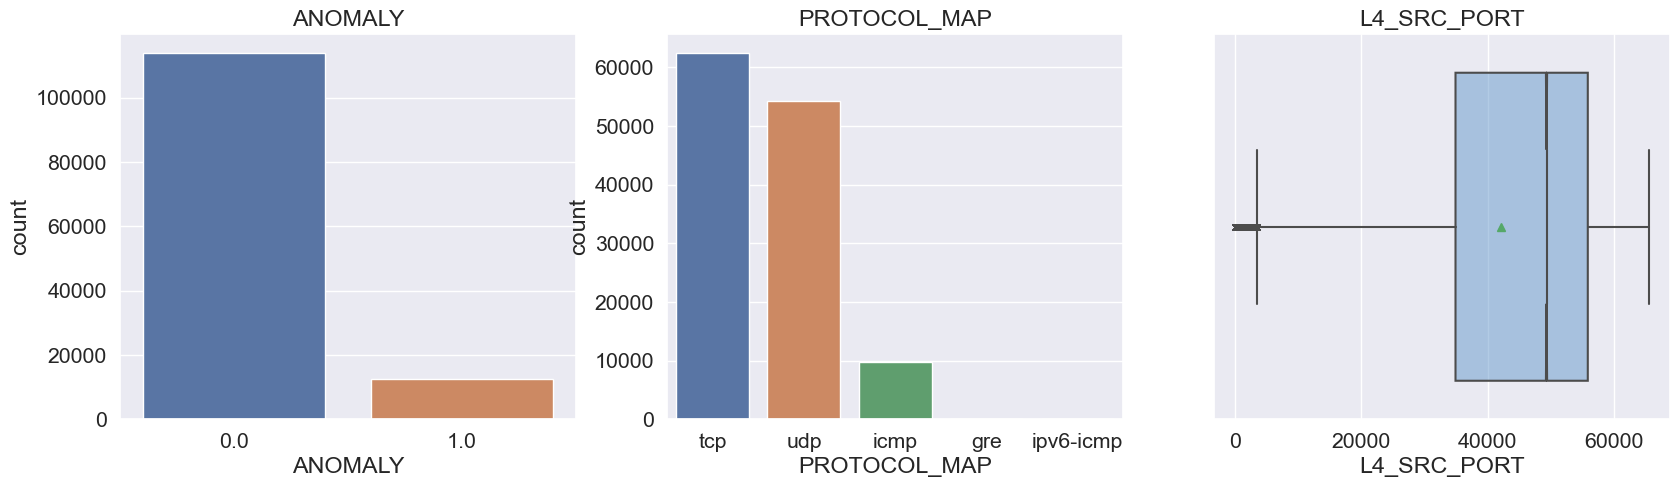

In [205]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# seaborn countplots
sns.countplot(x='ANOMALY', data=train_df, ax=axs[0]).set(title='ANOMALY')
              

# Seaborn countplot for the 'PROTOCOL_MAP' column, with enough space for the labels
sns.countplot(x='PROTOCOL_MAP', data=train_df, ax=axs[1]).set(title='PROTOCOL_MAP')

# Boxplot for L4_SRC_PORT to undestand the distribution of the data
sns.boxplot(
    x='L4_SRC_PORT', data=train_df, ax=axs[2],
    notch=True, showcaps=True,
    flierprops={"marker": "x"}, # Change the outlier marker
    showmeans=True, # Show the mean
    boxprops={"facecolor": (.4, .6, .8, .5)},
  ).set(title='L4_SRC_PORT')

### Protocol distribution in relation to the kind of attack

<Axes: xlabel='PROTOCOL_MAP', ylabel='count'>

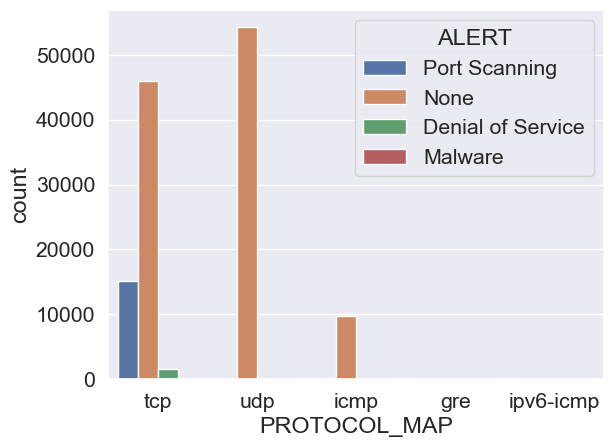

In [206]:
# Show protocol_map distribution for kind of ALERT
sns.countplot(x='PROTOCOL_MAP', hue='ALERT', data=train_df)

### 3.2 Unique hosts in dataset

Knowing the amount of unique hosts in the dataset is important to understand the size of the dataset since I expect that a bigger dataset will be more difficult to train properly.

In [207]:
# Find unique hosts (IP addresses) in the train and test data
train_src_hosts = train_df['IPV4_SRC_ADDR'].unique()
train_dst_hosts = train_df['IPV4_DST_ADDR'].unique()
train_hosts = np.union1d(train_src_hosts, train_dst_hosts)

# For each host, count the number of flows
print('Number of unique hosts in the train data: ', len(train_hosts))

# Find unique hosts (IP addresses) in the train and test data
test_src_hosts = test_df['IPV4_SRC_ADDR'].unique()
test_dst_hosts = test_df['IPV4_DST_ADDR'].unique()
test_hosts = np.union1d(test_src_hosts, test_dst_hosts)

# Floor ratio of hosts in test data that are not in train data
ratio = math.floor((1.0-len(test_hosts)/len(train_hosts)) * 100)

# For each host, count the number of flows
print("Number of unique hosts in the test data: {} (~{}% smaller)".format(len(test_hosts), ratio))


Number of unique hosts in the train data:  16875
Number of unique hosts in the test data: 11085 (~34% smaller)


### Distribution analysis using pairplot

In [208]:
# select the columns to be used for training
#train_df_columns = train_df[['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'OUT_PKTS', 'OUT_BYTES', 'ANOMALY', 'ALERT']]

# Distribution analysis using pairplot
# sns.pairplot(train_df_columns, hue='ALERT')

### Remove useless columns and create dummies

In [209]:
# Revoked columns
revoked_columns = [
  'FLOW_ID', # Completely random
  'ID', # Completely random
  'ANALYSIS_TIMESTAMP', # Completely random
  'IPV4_SRC_ADDR', # Not useful for the model
  'IPV4_DST_ADDR', # Not useful for the model
  'PROTOCOL_MAP', # There is a numerical column for the protocol
  'MIN_IP_PKT_LEN', # Always 0 since it is a minimum value
  'MAX_IP_PKT_LEN', # Always 0 (maybe it means that the packet have infinite length?)
  'TOTAL_PKTS_EXP', # Always 0
  'TOTAL_BYTES_EXP', # Always 0
]

# Create dummy columns for the ALERT column
alert_dummies = pd.get_dummies(train_df['ALERT'], prefix='ALERT', drop_first=True)

# Copy + drop the revoked columns
train_df = train_df.copy().drop(revoked_columns, axis=1)

### Correlation heatmap

We can observe that there are some features that are highly correlated with each other, such as **IN_BYTES** - **OUT_BYTES** and **IN_PKTS** - **OUT_PKTS**. This is not surprising, since these features are related to the amount of data exchanged between the two hosts.

We can also observe that a *port scanning* alert is highly correlated with the **L4_DST_PORT** and **ANOMALY** features. This is not surprising, since a port scanning attack is a type of attack that tries to find open ports on a host. It is highly correlated with **ANOMALY** probably because the forged packets are built in a way that they are not recognized as an attack by the network.

Unfortunately, since *malware attacks* alerts are various and have different characteristics/features, it is not possible to find a correlation between them and the other features. This could mean that the features used in this dataset are not enough to detect malware attacks.

In the other hand, *none* alerts are strongly negatively correlated with **ANOMALY** and **L4_DST_PORT**. This is not surprising, since a normally a flow contains valid packets and the destination is usually a well-known port.

<Axes: >

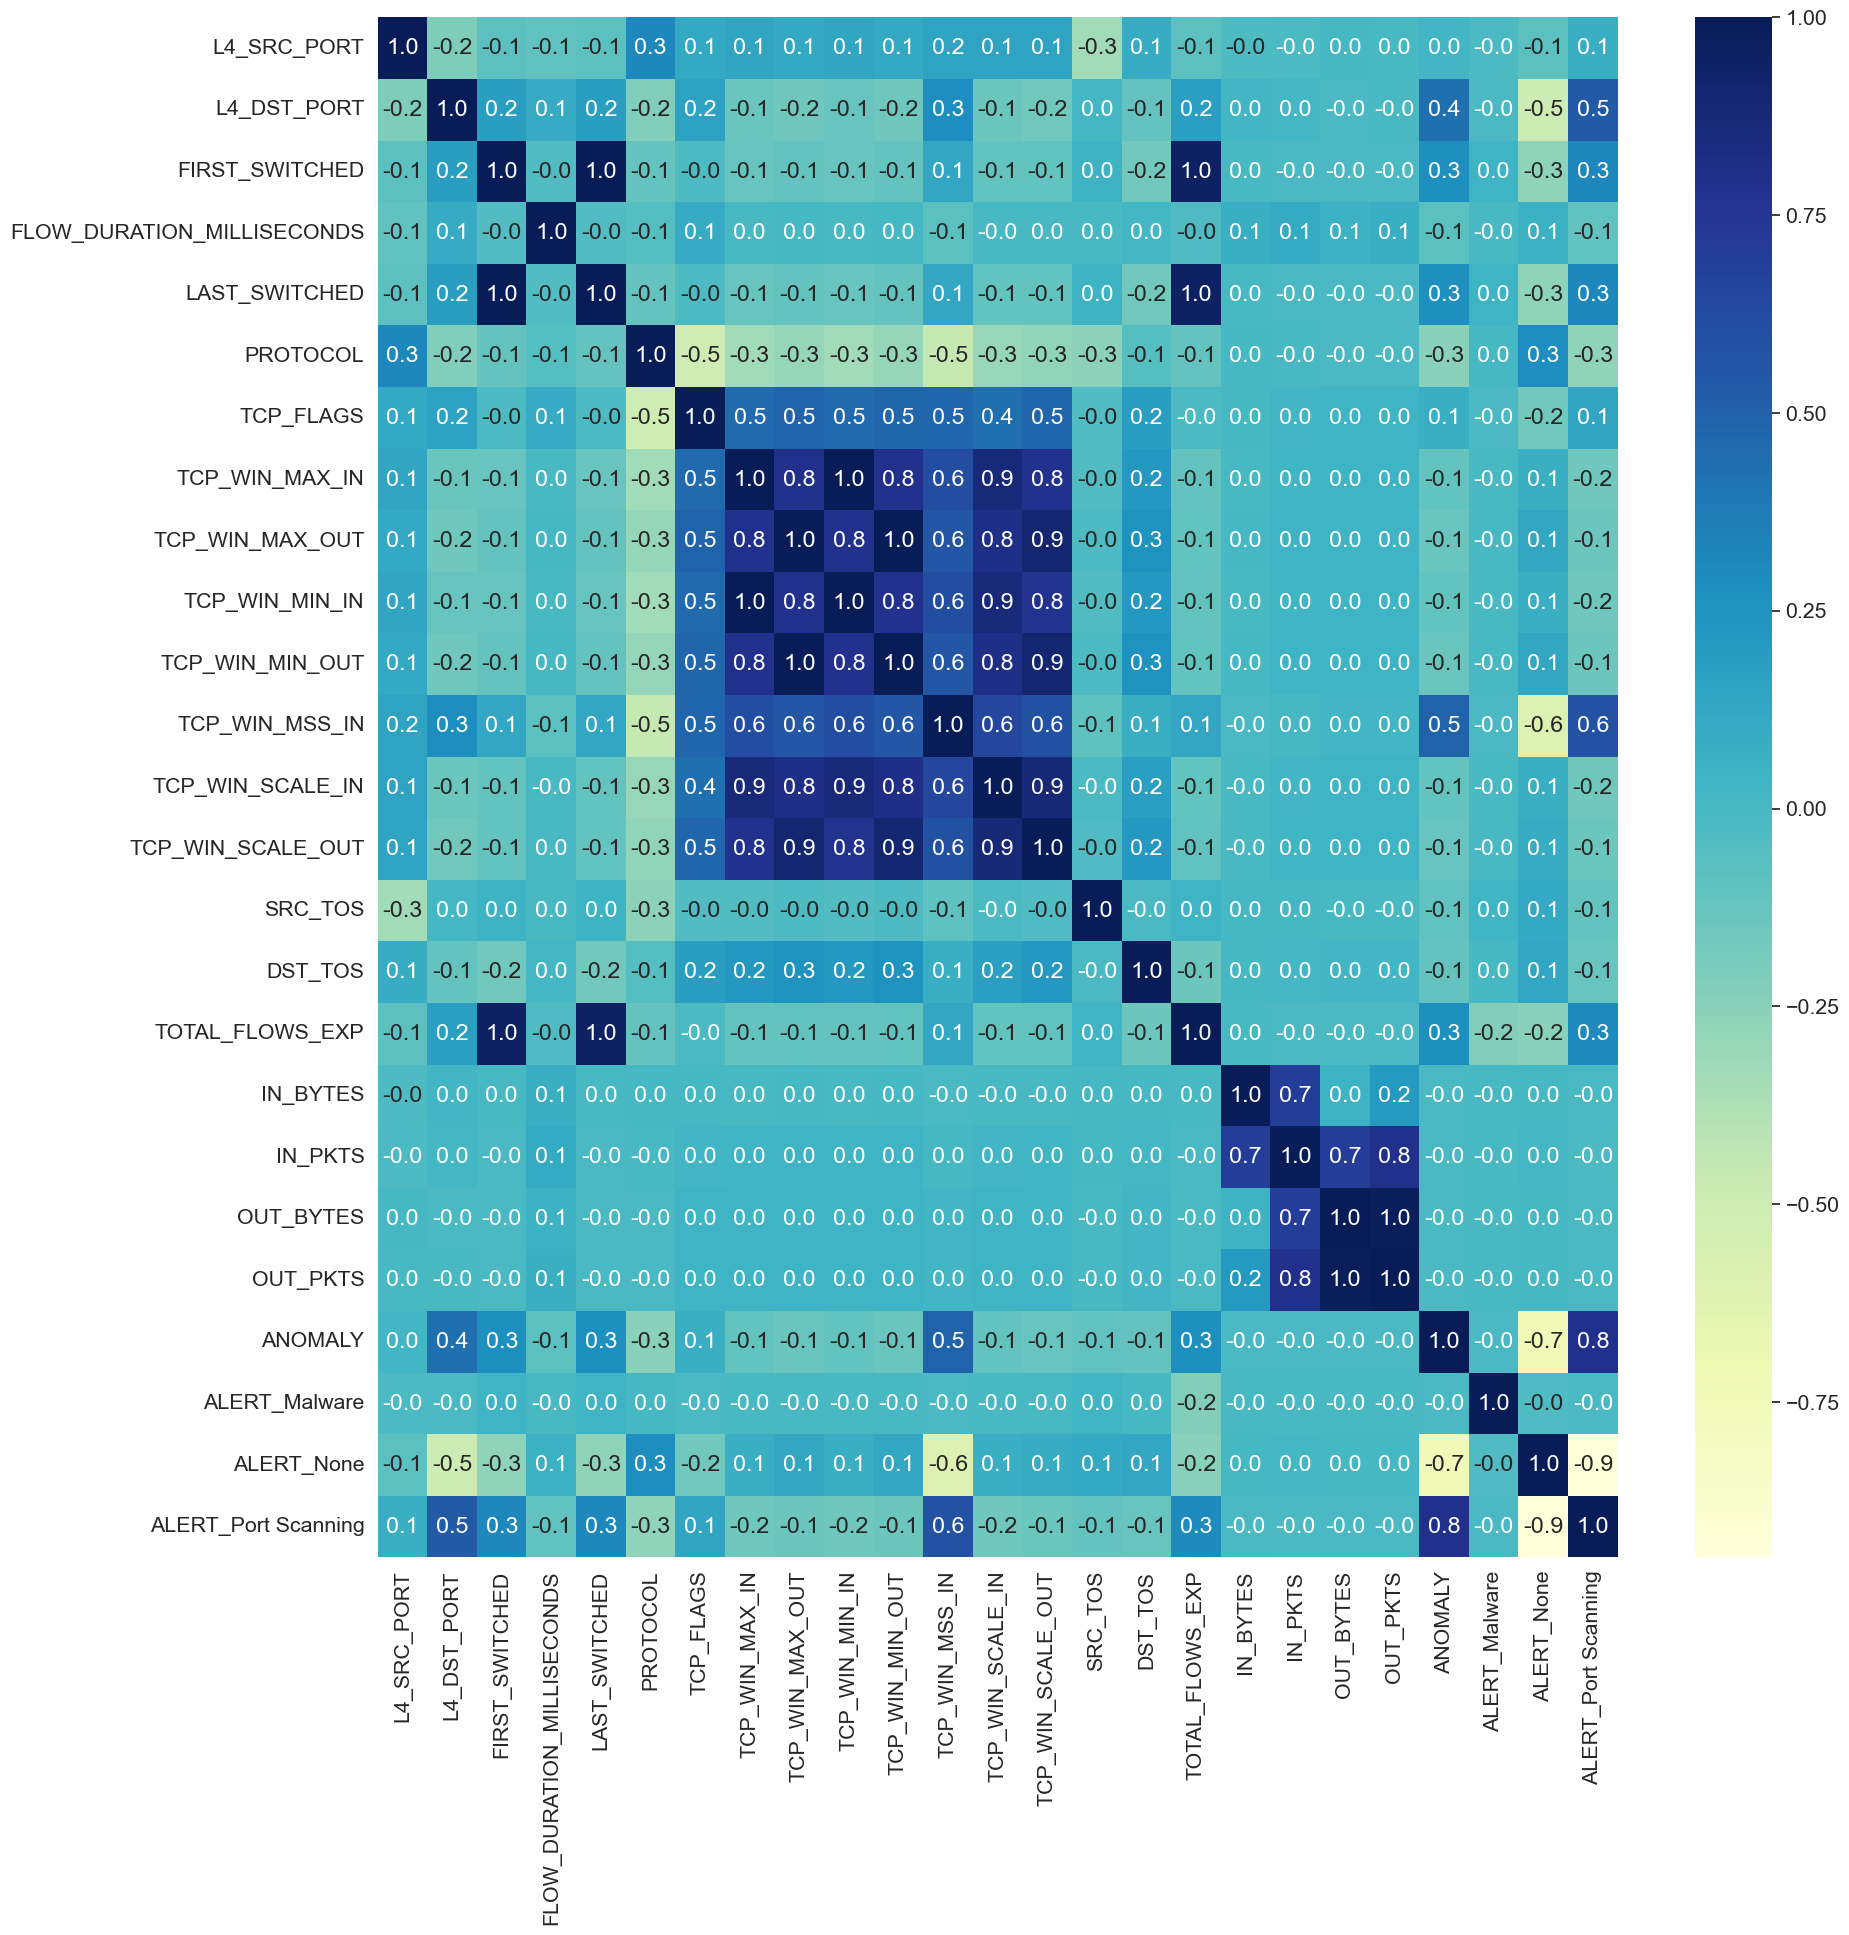

In [210]:
# Correlation heatmap using pandas
corr = pd.concat([train_df.drop('ALERT', axis=1), alert_dummies], axis=1).corr(
  numeric_only=False, # Only consider numeric columns
)

# Correlation heatmap using seaborn + make annotations fit the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt=".1f", cmap="YlGnBu")

## 5. Dataset splitting

Since we already have a test set, we split our training set in training and validation sets. We will use Sklearn's `StratifiedShuffleSplit` to split the training set in 80% training and 20% validation maintaining the same distribution of the target variable. This is needed since the dataset is highly imbalanced.

In [211]:
from sklearn.model_selection import StratifiedShuffleSplit
def split_maintain_distribution(X, y):
  sss=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=9)
  indexes = sss.split(train_df.drop('ALERT', axis=1), train_df['ALERT'])
  train_indices, test_indices = next(indexes)
  return X.iloc[train_indices], X.iloc[test_indices], y.iloc[train_indices], y.iloc[test_indices]

In [212]:
X_train, X_val, y_train, y_val = split_maintain_distribution(train_df.drop('ALERT', axis=1), train_df['ALERT'])

Now, check if actually the distribution of the target variable is the same in the training and validation sets.

In [213]:
# Print distribution of the target variable in the train and validation sets
print('Train set distribution:')
print(y_train.value_counts(normalize=True))
print()
print('Validation set distribution:')
print(y_val.value_counts(normalize=True))

Train set distribution:
None                 0.868508
Port Scanning        0.119380
Denial of Service    0.011983
Malware              0.000128
Name: ALERT, dtype: float64

Validation set distribution:
None                 0.868490
Port Scanning        0.119379
Denial of Service    0.011973
Malware              0.000158
Name: ALERT, dtype: float64


We can confirm that the distribution of the target variable is the same in the training and validation sets.

## 5.1. Data scaling

Scaling the data is important to avoid that some features will have a bigger impact on the model training than others. This is especially important 
when we are dealing with features that have different units of measure.

In [214]:
# Fix scaler on train set
scaler = StandardScaler()
fitter = scaler.fit(X_train)

# Scale train and validation sets
x_train_scaled = fitter.transform(X_train)
x_validation_scaled = fitter.transform(X_val)

# Convert to pandas dataframe
df_feat_train = pd.DataFrame(x_train_scaled, columns=X_train.columns)
df_feat_validation = pd.DataFrame(x_validation_scaled, columns=X_val.columns)

# 6. Finding the most important features

To have a better understanding of the dataset, we can use the **feature importance** technique to find the most important features in the dataset to later use them in the model training. This can be done using a **Random Forest** classifier.

## 6.1. Feature importance using Random Forest Classifier

In [215]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100)

# Fit the model
rfc.fit(x_train_scaled, y_train)

RandomForestClassifier()

In [216]:
# Print features importance
feature_importances = pd.DataFrame(
    rfc.feature_importances_,
    index=X_train.columns,
    columns=['importance']
).sort_values('importance', ascending=False)
print(feature_importances)

                            importance
IN_BYTES                      0.175958
ANOMALY                       0.131118
TCP_WIN_MSS_IN                0.119671
L4_DST_PORT                   0.099268
TCP_WIN_MIN_IN                0.092302
TCP_WIN_MAX_IN                0.061866
LAST_SWITCHED                 0.045237
TOTAL_FLOWS_EXP               0.043956
OUT_BYTES                     0.040899
FIRST_SWITCHED                0.034455
TCP_FLAGS                     0.027163
FLOW_DURATION_MILLISECONDS    0.027007
TCP_WIN_MAX_OUT               0.019829
L4_SRC_PORT                   0.019198
IN_PKTS                       0.017134
TCP_WIN_SCALE_IN              0.015457
SRC_TOS                       0.012362
TCP_WIN_MIN_OUT               0.008332
OUT_PKTS                      0.005977
TCP_WIN_SCALE_OUT             0.001595
DST_TOS                       0.001010
PROTOCOL                      0.000204


# 7. Feature selection
Select the most important features using the Random Forest classifier results (features with importance > 0.01)

In [217]:
# Select all columns with importance > 0.01
COLUMNS = feature_importances[feature_importances['importance'] > 0.01].index
COLUMNS

Index(['IN_BYTES', 'ANOMALY', 'TCP_WIN_MSS_IN', 'L4_DST_PORT',
       'TCP_WIN_MIN_IN', 'TCP_WIN_MAX_IN', 'LAST_SWITCHED', 'TOTAL_FLOWS_EXP',
       'OUT_BYTES', 'FIRST_SWITCHED', 'TCP_FLAGS',
       'FLOW_DURATION_MILLISECONDS', 'TCP_WIN_MAX_OUT', 'L4_SRC_PORT',
       'IN_PKTS', 'TCP_WIN_SCALE_IN', 'SRC_TOS'],
      dtype='object')

# 8. Data preparation for model training

## 8.1. Split again the training set in training and validation sets (with new columns)

In [218]:
X_train, X_val, y_train, y_val = split_maintain_distribution(
  train_df[COLUMNS],
  train_df['ALERT']
)

## 8.2. Data scaling (with new columns)

In [219]:
# Fix scaler on train set
scaler = StandardScaler()
fitter = scaler.fit(X_train)

# Scale train and validation sets
x_train_scaled = fitter.transform(X_train)
x_validation_scaled = fitter.transform(X_val)

# Convert to pandas dataframe
df_feat_train = pd.DataFrame(x_train_scaled, columns=X_train.columns)
df_feat_validation = pd.DataFrame(x_validation_scaled, columns=X_val.columns)

In [220]:
x_test_scaled = StandardScaler().fit_transform(test_df[COLUMNS])

# Convert to pandas dataframe
df_feat_test = pd.DataFrame(x_test_scaled, columns=test_df[COLUMNS].columns)

# 8. UMAP

## 8.1 Scale the data for UMAP visualization

In [221]:
import umap
reducer = umap.UMAP(
  random_state=42,
  n_neighbors=50,
  min_dist=0.3,
)
mapper = reducer.fit(x_train_scaled)

## 8.2. UMAP visualization

### 8.2.1. Visualization using matplotlib

Reduce data dimensionality to 2 dimensions and plot the data using matplotlib.

Text(0.5, 1.0, 'UMAP projection of the train set')

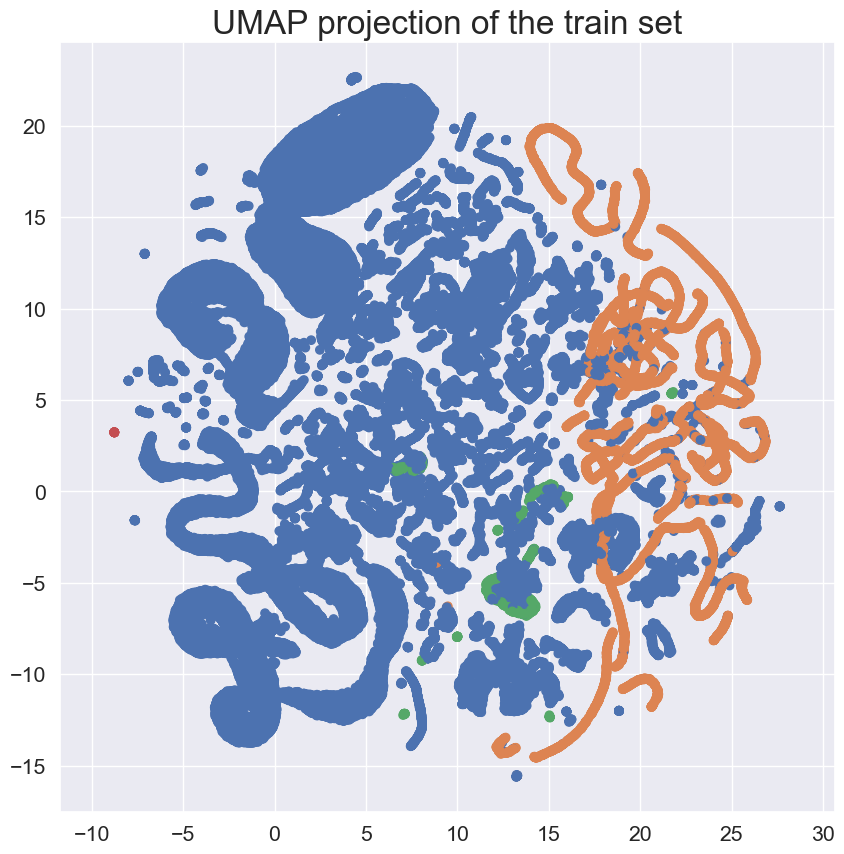

In [222]:
# Transform the train set
embedding = mapper.transform(x_train_scaled)

# Plot the train set
plt.figure(figsize=(10, 10))
plt.scatter(
  embedding[:, 0],
  embedding[:, 1],
  c=[sns.color_palette()[x] for x in y_train.map({'None': 0, 'Port Scanning': 1, 'Denial of Service': 2, 'Malware': 3})],
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the train set', fontsize=24)

### 8.2.2. Visualization using `umap.plot` and `bokeh` (interactive)

Plot the data using `umap.plot` and `bokeh` to have an interactive visualization.

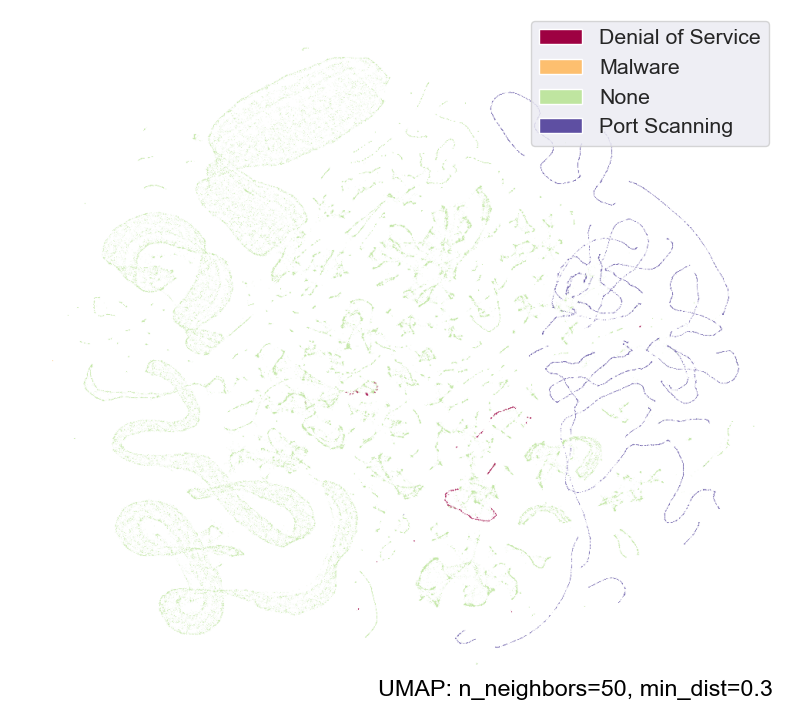

In [223]:
import umap.plot

# Create data labels
labels = y_train.map({'None': 0, 'Port Scanning': 1, 'Denial of Service': 2, 'Malware': 3})
# Visualize the embedding using umap.plot
p = umap.plot.points(
    mapper,
    labels=y_train,
    width=1000,
    height=900,
)
umap.plot.show(p)

# 4. Model Training

## 4.3. KNN Classifier training

### 4.3.1 Model training

In [224]:
# Create a KNN classifier with 3 neighbors
knn = KNeighborsClassifier(n_neighbors=3)
# Fit the classifier to the data
knn.fit(x_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=3)

In [225]:
# Print the accuracy
print("Score (accuracy): {}".format(knn.score(x_validation_scaled, y_val)))

Score (accuracy): 0.9977475697463052


In [226]:
# Make predictions on validation set
predictions = knn.predict(x_validation_scaled)

In [227]:
# Print the classification report
print(classification_report(y_val, predictions))

                   precision    recall  f1-score   support

Denial of Service       0.94      1.00      0.97       303
          Malware       1.00      1.00      1.00         4
             None       1.00      1.00      1.00     21978
    Port Scanning       0.99      1.00      0.99      3021

         accuracy                           1.00     25306
        macro avg       0.98      1.00      0.99     25306
     weighted avg       1.00      1.00      1.00     25306



We can notice that the model is excessively precise, with a precision of 1.0 with any kind of attack. This is probably due to the fact that the dataset is highly imbalanced, with the majority of the flows being normal (no attack detected). We can also observe that also the number of malware attacks is very low, compared to the other attacks.

In [228]:
# Print the confusion matrix for the predictions
cmat = confusion_matrix(y_val, predictions)
cmat

array([[  303,     0,     0,     0],
       [    0,     4,     0,     0],
       [   19,     0, 21921,    38],
       [    0,     0,     0,  3021]])

<Axes: >

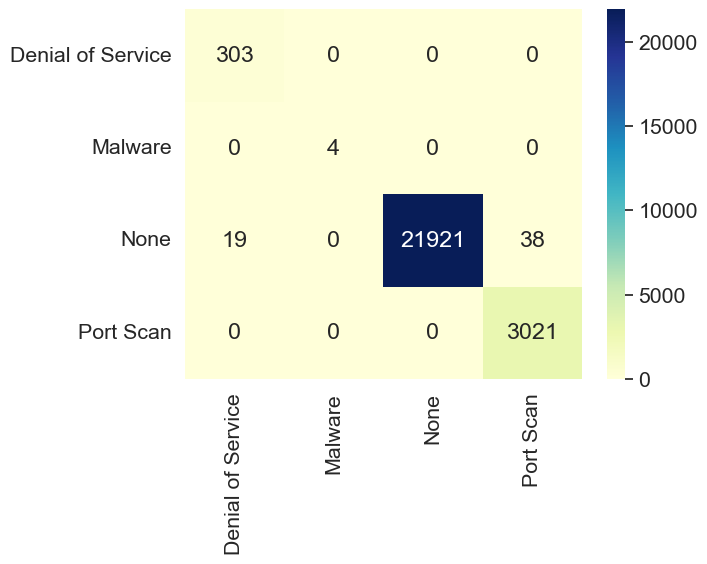

In [229]:
# Rename the columns and index for the confusion matrix
cmat = pd.DataFrame(cmat, index=['Denial of Service', 'Malware', 'None', 'Port Scan'], columns=['Denial of Service', 'Malware', 'None', 'Port Scan'])

# Use seaborn to visualize the confusion matrix
sns.set(font_scale=1.4) # for label size
sns.heatmap(cmat, annot=True, fmt='d', cmap='YlGnBu')

### 4.3.3 Finding the best K hyperparameter for KNN

To find the best K hyperparameter for KNN, we will use the **validation set** to find the best K value. We will then use this K value to train the model on the **training set** and evaluate it on the **test set**.

In [238]:
# General imports
error_rate = []
for i in range(1, 20):
    knn_temp = KNeighborsClassifier(n_neighbors=i)
    knn_temp.fit(x_train_scaled, y_train)
    pred_i = knn.predict(x_validation_scaled)
    error_rate.append(np.mean(pred_i != y_val))

# Print the best k
print("Best k: {}".format(error_rate.index(min(error_rate)) + 1))

KeyboardInterrupt: 

Text(0, 0.5, 'Error Rate')

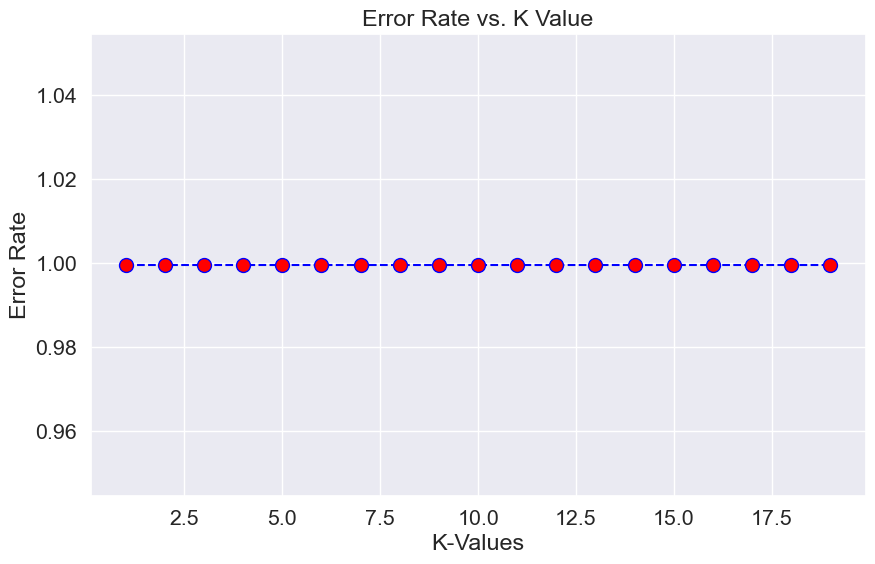

In [231]:
# Plot the error rate
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), error_rate, color='blue', linestyle='dashed', marker='o',
          markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K-Values')
plt.ylabel('Error Rate')

The best parameter for KNN is **K = 1**.

This outcome is not surprising since the training and validation sets are coming probably from the same network and the same hosts, so the flows are very similar to each other. This means that the best way to test our model is to use the **test set**.

## 4.4. KNN Classifier with Cross Validation

### 4.4.1. Folds

In [232]:
# Cross-validation for the KNN model
from sklearn.model_selection import cross_val_score

# Train model with 5-fold cv
cv_scores = cross_val_score(KNeighborsClassifier(n_neighbors=3), x_train_scaled, y_train, cv=5)

In [233]:
# Print the mean of the scores (accuracy)
print('Cross-validated scores (accuracy):', np.mean(cv_scores))

Cross-validated scores (accuracy): 0.9973622565383966


### 4.4.2. Model performance on test set

Unfortunately, the test set doesn't include the target variable, so we can't evaluate the model on it. We can only evaluate the model on the validation set.

In [234]:
# Prediction on the test set
predictions = knn.predict(x_test_scaled)

None                 53930
Port Scanning         7611
Denial of Service      774
Malware                  5
dtype: int64

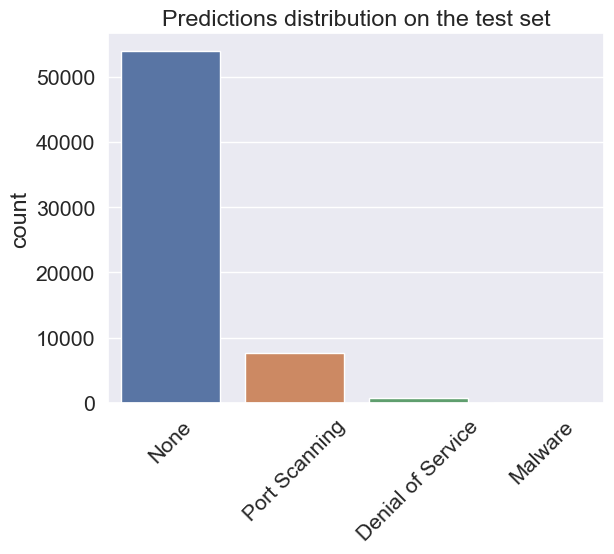

In [235]:
# Show the predictions on a histogram
fig = sns.countplot(
  x=predictions
)

# Set the title
fig.set_title('Predictions distribution on the test set')

# Rotate x-labels
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)

# Print the predictions size per class
pd.Series(predictions).value_counts()


## 4.5. Support Vector Machine Classifier (SVC)

### 4.5.1. Model training

In [236]:
## 4.5. Support Vector Machines (SVM) classifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV


# Define a pipeline combining a PCA and the SVC

# PCA (Principal Component Analysis):
#  - Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space.
pca = PCA(n_components=10, whiten=True, random_state=42)
# SVC (Support Vector Classification)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

Grid search to find the best parameter for SVC.

Best parameters:

- `C` = 100
- `Gamma` = '10'

In [237]:
param_grid = {
  'svc__C': [5, 10, 50, 100, 500],
  'svc__gamma': [0.001, 0.01, 0.1, 1, 10]
}

# Grid search 
grid = GridSearchCV(
    model,
    param_grid,
    verbose=1,
    cv=2, # Only 1 folds because of the size of the dataset, otherwise it takes too long
    n_jobs=-1 # Use all cores
)
grid.fit(x_train_scaled, y_train)
best_params = grid.best_params_
print(f"Best params: {best_params}")


Fitting 2 folds for each of 25 candidates, totalling 50 fits


KeyboardInterrupt: 

In [ ]:
# Now, create the desired pipeline
pca = PCA(n_components=10, whiten=True, random_state=42)
svc = SVC(kernel='rbf',
  class_weight='balanced',
  C=100,
  gamma=10
)
model = make_pipeline(pca, svc)
model.fit(x_train_scaled, y_train)

Pipeline(steps=[('pca', PCA(n_components=10, random_state=42, whiten=True)),
                ('svc', SVC(C=100, class_weight='balanced', gamma=10))])

In [ ]:
# Make predictions on validation set
predictions = model.predict(x_validation_scaled)

# Print the classification report
print(classification_report(y_val, predictions))

                   precision    recall  f1-score   support

Denial of Service       0.99      1.00      1.00       303
          Malware       1.00      0.75      0.86         4
             None       1.00      1.00      1.00     21978
    Port Scanning       0.99      1.00      1.00      3021

         accuracy                           1.00     25306
        macro avg       1.00      0.94      0.96     25306
     weighted avg       1.00      1.00      1.00     25306



In [ ]:
# Print the confusion matrix for the predictions
cmat = confusion_matrix(y_val, predictions)
cmat

array([[  303,     0,     0,     0],
       [    0,     3,     1,     0],
       [    3,     0, 21950,    25],
       [    0,     0,     1,  3020]])

<Axes: >

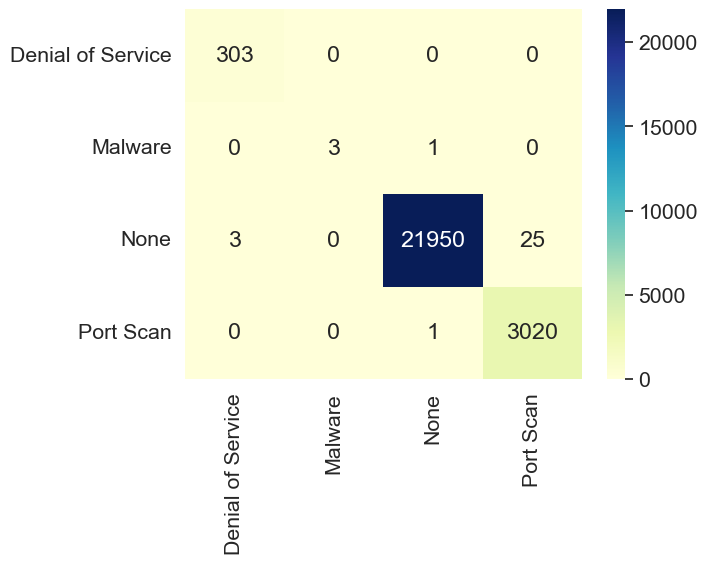

In [ ]:
# Rename the columns and index for the confusion matrix
cmat = pd.DataFrame(cmat, index=['Denial of Service', 'Malware', 'None', 'Port Scan'], columns=['Denial of Service', 'Malware', 'None', 'Port Scan'])

# Use seaborn to visualize the confusion matrix
sns.set(font_scale=1.4) # for label size
sns.heatmap(cmat, annot=True, fmt='d', cmap='YlGnBu')

## 4.6. Bagging Classifier (SVC based)

In [247]:
from sklearn.ensemble import BaggingClassifier

svc = SVC(kernel='rbf',
  class_weight='balanced',
  C=100,
  gamma=10
)

clf = BaggingClassifier(
  svc,
  n_estimators=30,
  n_jobs=-1, # Use aimage.pngll cores
  random_state=42
)
clf.fit(x_train_scaled, y_train)

KeyboardInterrupt: 

In [ ]:
predictions = clf.predict(x_validation_scaled)
# Print the classification report
print(classification_report(y_val, predictions))

                   precision    recall  f1-score   support

Denial of Service       0.53      1.00      0.70       303
          Malware       1.00      1.00      1.00         4
             None       1.00      0.98      0.99     21978
    Port Scanning       0.97      1.00      0.98      3021

         accuracy                           0.99     25306
        macro avg       0.87      1.00      0.92     25306
     weighted avg       0.99      0.99      0.99     25306



In [ ]:
# Print the confusion matrix for the predictions
cmat = confusion_matrix(y_val, predictions)
cmat

In [ ]:
# Rename the columns and index for the confusion matrix
cmat = pd.DataFrame(cmat, index=['Denial of Service', 'Malware', 'None', 'Port Scan'], columns=['Denial of Service', 'Malware', 'None', 'Port Scan'])

# Use seaborn to visualize the confusion matrix
sns.set(font_scale=1.4) # for label size
sns.heatmap(cmat, annot=True, fmt='d', cmap='YlGnBu')